In [2]:
library(Seurat)
library(maftools)
options(stringsAsFactors = F)
library(ggplot2)
library(VariantAnnotation)
#setwd('G:/3D2/wes2')
setwd('/home/wyh/scdata/WES_V2/')

Attaching SeuratObject

Attaching sp



# data preparation

## Map the clinical patient name and standardalized name

In [681]:
## rename
vcf = read.csv("./annovar_merge_20_3_0015_005.vcf",header = FALSE,sep = "\t")
colnames = vcf[1,]
vcf = vcf[2:dim(vcf)[1],]
colnames[length(colnames)] = "normal_sample"
colnames(vcf) = c(colnames)
sample_name_df = read.csv("./file_rename.csv",row.names = 1)
vcf$Tumor_Sample_Barcode = sample_name_df[vcf$Tumor_Sample_Barcode,2]
write.table(vcf, file = "annovar_merge_20_3_0015_005_rename.vcf", sep = "\t", row.names = FALSE, quote = FALSE)

In [11]:
patient_info = read.csv("../patient_info/xzh_220109_final_wyh_220426.csv",row.names = 1)
patient_info$Tumor_Sample_Barcode = rownames(patient_info)

In [683]:
## annovar
laml <- annovarToMaf(annovar = "annovar_merge_20_3_0015_005_rename.vcf", 
                             refBuild = 'hg38',
                             tsbCol = 'Tumor_Sample_Barcode', 
                             table = 'refGene',
                             MAFobj = T,
                            sampleAnno = data.table::data.table(patient_info))

-Reading annovar files
-Processing Exonic variants
--Adding Variant_Classification
--Parsing aa-change
-Processing Non-exonic variants
--Adding Variant_Classification
-Adding Variant_Type
Finished in 5.215s elapsed (5.927s cpu) 


In [684]:
variants_number = as.data.frame(laml@variants.per.sample)
variants_number[108,] = c("GBC_002_P",0)
rownames(variants_number) = variants_number[,1]

In [685]:
write.csv(variants_number,'./variants_number.csv')

In [686]:
hyper_sample = as.data.frame(laml@variants.per.sample)
hyper_sample = hyper_sample[,1][hyper_sample[,2]>1000]
hyper_sample

[1] GBC_026_P  GBC_037_P  GBC_071_LI
108 Levels: GBC_002_P GBC_003_P GBC_004_P GBC_005_P GBC_006_P ... GBC_087_P

In [687]:
laml_filter = subsetMaf(laml,mafObj = TRUE,
                 tsb = laml@clinical.data$NewSample.ID[!(laml@clinical.data$NewSample.ID %in% hyper_sample)])

In [688]:
setdiff(laml@clinical.data$NewSample.ID[!(laml@clinical.data$NewSample.ID %in% hyper_sample)],laml_filter@clinical.data$NewSample.ID)

[1] "GBC_002_P"

In [689]:
for(i in 1:nrow(laml_filter@data)){
    if(strsplit(as.character(laml_filter@data[i,'Otherinfo13']),":")[[1]][1] %in% c("0|0","0/0")){
        # print(i)
        temp = laml_filter@data[i,'Otherinfo13']
        laml_filter@data[i,'Otherinfo13'] = laml_filter@data[i,'Otherinfo12']
        laml_filter@data[i,'Otherinfo12'] = temp
        # print(laml_filter@data[i,'Otherinfo12'])
    }
}

In [690]:
for(i in 1:nrow(laml_filter@maf.silent)){
    if(strsplit(as.character(laml_filter@maf.silent[i,'Otherinfo13']),":")[[1]][1] %in% c("0|0","0/0")){
        # print(i)
        temp = laml_filter@maf.silent[i,'Otherinfo13']
        laml_filter@maf.silent[i,'Otherinfo13'] = laml_filter@maf.silent[i,'Otherinfo12']
        laml_filter@maf.silent[i,'Otherinfo12'] = temp
        # print(laml_filter@data[i,'Otherinfo12'])
    }
}

In [691]:
saveRDS(laml_filter,"laml_filter_20_3_0015_005.RDS")

In [692]:
write.csv(rbind(laml_filter@data,laml_filter@maf.silent),"./pair_sample_wes/pairtree/wes_all.csv")

In [1258]:
wes_info = laml_filter@variant.classification.summary
wes_info = as.data.frame(wes_info)
rownames(wes_info) = wes_info$Tumor_Sample_Barcode

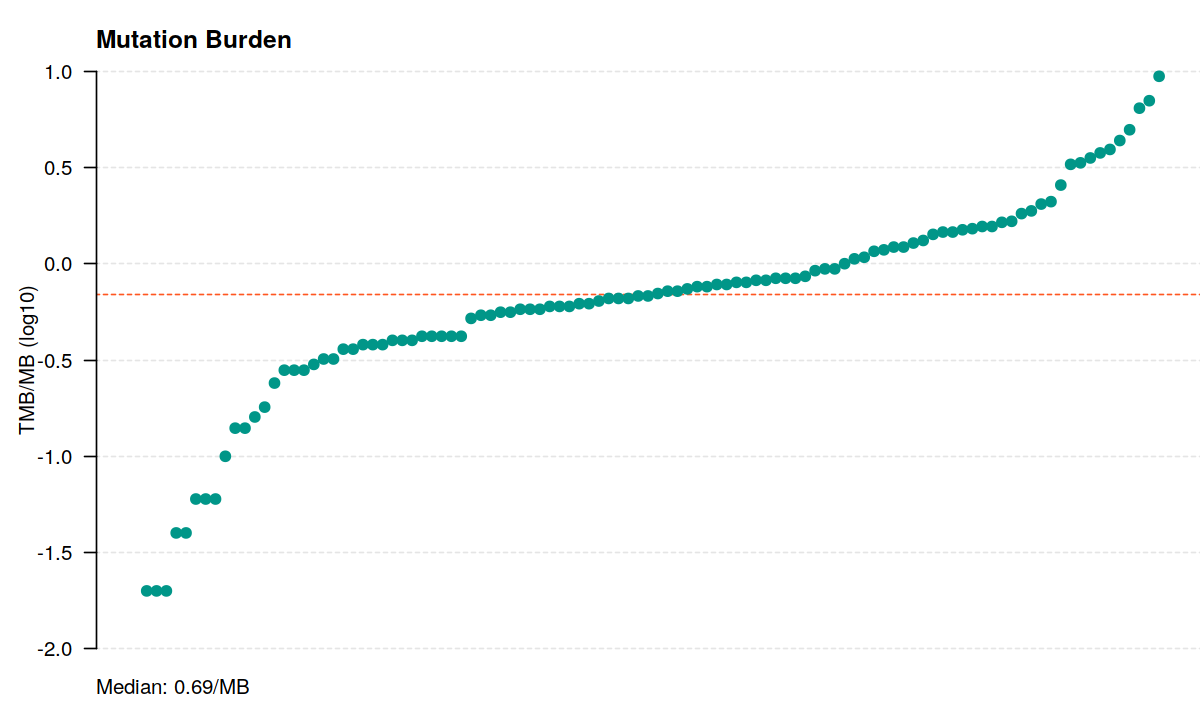

In [1259]:
variants_number = tmb(maf = laml_filter)
variants_number = as.data.frame(variants_number)

In [1260]:
wes_info$TMB = wes_info$total/50

In [1265]:
wes_info$Tumor_Sample_Barcode = as.character(wes_info$Tumor_Sample_Barcode)

In [1266]:
wes_info['GBC_002_P',] = 0
wes_info["GBC_002_P","Tumor_Sample_Barcode"] = "GBC_002_P"

In [1268]:
write.csv(wes_info,"./summary/wes_info.csv")

## MutsigCV

In [189]:
library(maftools)

In [121]:
laml_filter = readRDS("laml_filter_20_3_0015_005.RDS")

In [151]:
laml_filter@data[,'Tumor_Seq_Allele1'] = laml_filter@data[,'Tumor_Seq_Allele2']
laml_filter@data[,'Tumor_Seq_Allele2'] = laml_filter@data[,'Reference_Allele']

In [152]:
laml_filter.corrected = prepareMutSig(maf = laml_filter,"./MutSig/laml_filter.corrected.maf")
# laml_filter@data = laml_filter.corrected
# laml_filter@data = laml_filter@data[,c("Hugo_Symbol","Tumor_Sample_Barcode")]

Converting gene names for 485 variants from 282 genes



     Hugo_Symbol MutSig_Synonym  N
  1:       DISP3         PTCHD2 10
  2:       KMT2D           MLL2  9
  3:      PRRC2B         BAT2L1  8
  4:       KMT2C           MLL3  7
  5:      BRINP1           DBC1  5
 ---                              
278:        DPH7          WDR85  1
279:      ZNF106         ZFP106  1
280:      ZBTB14         ZFP161  1
281:        RBSN        ZFYVE20  1
282:     ZSCAN30       ZNF397OS  1


Original symbols are preserved under column OG_Hugo_Symbol.



In [153]:
laml_filter.corrected = read.maf("./MutSig/laml_filter.corrected.maf.mutSig.maf")

-Reading
-Validating
--Non MAF specific values in Variant_Classification column:
  Unknown
--Non MAF specific values in Variant_Type column:
  MNP
-Silent variants: 2633 
-Summarizing
--Possible FLAGS among top ten genes:
  MUC5B
  TTN
  MUC16
  FLG
  PLEC
-Processing clinical data
--Missing clinical data
-Finished in 0.580s elapsed (2.884s cpu) 


In [154]:
laml_filter.corrected@maf.silent = laml_filter.corrected@maf.silent[laml_filter.corrected@maf.silent$Variant_Classification!="RNA",]

In [430]:
write.mafSummary(laml_filter.corrected,"./MutSig/GBC_Mutsig.maf")

In [1064]:
## Hugo_Symbol

In [1056]:
MutsigCV = read.csv("./MutSig/ans/GBC_MutSig.sig_genes.txt",sep = "\t")
rownames(MutsigCV) = MutsigCV$gene
correctedSymbols = read.csv("./MutSig/laml_filter.corrected.maf.correctedSymbols.tsv",sep = "\t")
rownames(correctedSymbols) = correctedSymbols$MutSig_Synonym

In [1057]:
MutsigCV = MutsigCV[MutsigCV$gene[MutsigCV$gene %in% c(unique(laml_filter.corrected@data$Hugo_Symbol),unique(laml_filter.corrected@maf.silent$Hugo_Symbol))],]

In [1059]:
MutsigCV[MutsigCV$gene[MutsigCV$gene %in% correctedSymbols$MutSig_Synonym],"gene"] = correctedSymbols[MutsigCV$gene[MutsigCV$gene %in% correctedSymbols$MutSig_Synonym],"Hugo_Symbol"]

In [1063]:
write.table(MutsigCV,"./MutSig/ans/GBC_MutSig.sig_genes_Hugo_Symbol.txt",sep = "\t")

# mutation analysis

## 1.acquire mutation matrix

In [341]:
laml_filter = readRDS("laml_filter_20_3_0015_005.RDS")

In [ ]:
oncoplot(maf = laml_filter,
         fontSize = 1,
         removeNonMutated = FALSE,
         top = length(unique(laml_filter@data$Hugo_Symbol)),
         cohortSize = length(unique(laml_filter@data$Tumor_Sample_Barcode)),
         #genes = unique(c(gene28,gene51,gene52)),
         #genes = lung,
         #sampleOrder =  c("LC28-Tumor" ,"LC28-LCA","LC51-Tumor" ,"LC51-LCA","LC52-Tumor" ,"LC52-LCA"),
         # sampleOrder = laml@clinical.data$Tumor_Sample_Barcode,
         showTumorSampleBarcodes = T,
         borderCol = "white",
         #colors = color_maf,
         
         gene_mar = 10,
         bgCol  = "white",
         barcodeSrt=45,
         writeMatrix = TRUE)

In [165]:
onco_matrix_all = read.csv("./onco_matrix.txt",header = T, check.names = F, sep = "\t")

In [698]:
onco_matrix_all$GBC_002_P = ''
write.csv(onco_matrix_all,"./onco_matrix_105_patient.csv")

###  top mutation in other article

In [ ]:
### Genomic ERBB2/ ERBB3 mutations promote PD-L1-mediated immune escape in gallbladder cancer: a whole-exome sequencing analysis mutation_gene_Li2018，里面包含2014年的数据
### Integrative molecular characterisation of gallbladder cancer reveals micro-environment-associated subtypes Nepal2021
## Li2018 are curated manually

In [15]:
wes = read.csv("../WES/public/Nepal2021.txt",header = TRUE,sep = "\t")

In [12]:
wes = read.csv("../WES/public/Nepal2021.txt",header = TRUE,sep = "\t")
gene_list = list()
for(ipatient in unique(wes$Tumor.ID)){
  gene_list[[ipatient]] = unique(wes[wes$Tumor.ID==ipatient,'HUGO.symbol'])
  if(sum(duplicated(wes[wes$Tumor.ID==ipatient,'HUGO.symbol']))!=0){
    print(ipatient)
  }
}

gene_list1 = unlist(gene_list)
gene_list1 = as.data.frame.array(table(gene_list1))
gene_list1$name = rownames(gene_list1)
gene_list1 = gene_list1[order(-gene_list1$`table(gene_list1)`),]
gene_list1

[1] "GBC_0315Tumor"
[1] "GBC_0448Tumor"
[1] "GBC_0551Tumor"
[1] "GBC_0584Tumor"
[1] "GBC_0687Tumor"
[1] "GBC_0719Tumor"
[1] "GBC_0824Tumor"
[1] "GBC_0859Tumor"
[1] "GBC_0899Tumor"
[1] "GBC_0973Tumor"
[1] "GBC_1040Tumor"
[1] "GBC_1070Tumor"
[1] "GBC_1166Tumor"
[1] "GBC_1341Tumor"
[1] "GBC_1404Tumor"
[1] "GBC_1456Tumor"
[1] "GBC_1483Tumor"
[1] "GBC_1609Tumor"
[1] "GBC_1740Tumor"
[1] "GBC_1785Tumor"
[1] "GBC_1829Tumor"
[1] "GBC_1916Tumor"
[1] "GBC_3120Tumor"
[1] "GBC_A000024Tumor"
[1] "GBC_A000033Tumor"
[1] "GBC_A000034Tumor"
[1] "GBC_A000076Tumor"
[1] "GBC_A000156Tumor"
[1] "GBC_A000186Tumor"
[1] "GBC_A000191Tumor"
[1] "HDG01Tumor"
[1] "HDG02Tumor"
[1] "HDG04Tumor"
[1] "HDG05Tumor"
[1] "HDG06Tumor"
[1] "HDG07Tumor"
[1] "HDG08Tumor"
[1] "HDG10Tumor"
[1] "HDG16Tumor"
[1] "HDG17Tumor"
[1] "HDG22Tumor"
[1] "HDG23Tumor"
[1] "HDG27Tumor"
[1] "HDG29Tumor"
[1] "HDG34Tumor"
[1] "HDG35Tumor"
[1] "HDG38Tumor"


,table(gene_list1),name
,<int>,<chr>
TP53,27,TP53
CTBP2,7,CTBP2
MYO15A,7,MYO15A
CRIPAK,6,CRIPAK
DNAH17,6,DNAH17
ELF3,6,ELF3
XIRP2,6,XIRP2
AATK,5,AATK
ARID2,5,ARID2


In [17]:
mutation_gene_Zhou2023 = row.names(read.csv("./onco_matrix_filter.csv",row.names = 1))[1:30]

In [15]:
top_gene_mutation_rate = data.frame(row.names = mutation_gene_Zhou2023,Nepal2021 = gene_list1[mutation_gene_Zhou2023,1]/92)

In [16]:
write.csv(top_gene_mutation_rate,"../WES/public/top_gene_mutation_rateV3.csv")

#### Giraldo et al.

In [26]:
mutation_gene_Giraldo2022 = c("TP53","MDM2","CDKN2A","CDKN2B","CCNE1","CDK4","CDK6","RB1","ERBB2","ERBB3","KRAS","ARID1A","ARID2","KMT2C","PIK3CA"
,'STK11','PTEN','SMAD4','CTNNB1',"MYC","ELF3","TERT")

In [28]:
top_gene_mutation_rate = data.frame(row.names = mutation_gene_Giraldo2022,Nepal2021 = gene_list1[mutation_gene_Giraldo2022,1]/92)
write.csv(top_gene_mutation_rate,"./public/Nepal2021_top_gene_mutation_rate_Giraldo2022.csv")

In [47]:
onco_matrix_all = read.csv("./onco_matrix_105_patient.csv",row.names = 1)
# onco_matrix_filter = read.csv("./onco_matrix_filter.csv",row.names = 1)

In [70]:
onco_matrix_all[,'GBC_049_P'] = ''

In [74]:
gene_list_Zhou = rowSums(onco_matrix_all!='')/105
top_gene_mutation_rate = data.frame(row.names = mutation_gene_Giraldo2022,Nepal2021 = gene_list_Zhou[mutation_gene_Giraldo2022])
write.csv(top_gene_mutation_rate,"./public/Zhou2024_top_gene_mutation_rate_Giraldo2022.csv")

In [76]:
write.csv(top_gene_mutation_rate,"./public/public_finalV4.csv")

In [ ]:
##plot

In [80]:
library(reshape2)

Warning message:
“package ‘reshape2’ was built under R version 4.0.5”


In [1205]:
data = read.csv("./public/public_finalV4.csv",row.names = 1)

In [1217]:
data_plot = melt(data,id.vars = "Gene")
colnames(data_plot) = c("Gene","Cohort","Pertentage")
data_plot$Cohort = factor(data_plot$Cohort,levels = c("Our.cohort","Li2018","Nepal2021","Giraldo2022"))

Warning message in melt(data, id.vars = "Gene"):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data). In the next version, this warning will become an error.”


In [1223]:
data_plot$Gene = factor(data_plot$Gene,levels = unique(data_plot$Gene))

In [1226]:
library(ggplot2)
pdf("./public/mutation_compareV2.pdf",height = 3,width = 9)
ggplot(data_plot,aes(x = Cohort,y = Pertentage))+geom_col(aes(fill = Cohort),position = 
                                                  position_dodge())+facet_wrap(.~Gene,nrow = 2)+
theme_bw()+
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())
dev.off()

png 
  2

### oncoplot 
https://blog.csdn.net/weixin_41368414/article/details/125174493

In [4]:
library(maftools)
library(ComplexHeatmap)
library(reshape2)

Loading required package: grid

ComplexHeatmap version 2.13.1
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


Warning message:
“package ‘reshape2’ was built under R version 4.0.5”


#### version 1, mutsigcv

In [5]:
library("formattable")
library(scales)
library(circlize)
color = read.csv("../figures/palette_celltype_outputV2.csv",row.names = 1)
mycol = c("#51574a","#e9d78e",ggsci::pal_d3("category20")(20)[1:20])


Attaching package: ‘formattable’


The following object is masked from ‘package:BiocGenerics’:

    normalize



Attaching package: ‘scales’


The following objects are masked from ‘package:formattable’:

    comma, percent, scientific


circlize version 0.4.15
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))




In [7]:
### 1.1 data prepare
matMut = read.csv("./onco_matrix_105_patient.csv",row.names = 1)
matMut['GBC_002_P'] = ''
MutsigCV = read.csv("./MutSig/ans/GBC_MutSig.sig_genes_Hugo_Symbol.txt",sep = "\t")
matMut = matMut[MutsigCV$gene[1:20],]

In [8]:
matMut[matMut == "In-frame"] = "In_frame"
matMuttmp = matMut
matMuttmp$gene = row.names(matMuttmp)
mat_long <- melt(matMuttmp, id.vars = "gene", value.name = "Variant_Classification")
levels(factor(mat_long$Variant_Classification))
## [1] ""           "In_frame"   "Missense"   "Multi_Hit"  "Truncating"
freq_mut = as.data.frame.array(table(mat_long$Variant_Classification))
freq = freq_mut[2:8,]
names(freq) = rownames(freq_mut)[2:8]
freq = sort(freq,decreasing = TRUE)
freq

[1] ""                       "Frame_Shift_Del"        "Frame_Shift_Ins"       
[4] "In_Frame_Del"           "In_Frame_Ins"           "Missense_Mutation"     
[7] "Multi_Hit"              "Nonsense_Mutation"      "Translation_Start_Site"

Missense_Mutation Nonsense_Mutation   Frame_Shift_Del         Multi_Hit 
               52                34                20                13 
  Frame_Shift_Ins      In_Frame_Ins      In_Frame_Del 
                6                 4                 2

In [9]:
### 1.2. alter_fun plot
#col_metastasis.type = c(P = "red",P_LN = "blue",P_LM = "yellow")
col <- c(Frame_Shift_Del = "purple", Frame_Shift_Ins = "orange", In_Frame_Del = "black", In_Frame_Ins = "blue",
         Missense_Mutation = "red",Multi_Hit = "yellow",Nonsense_Mutation = "blue")
## 
col <- c(Missense_Mutation = "#d62728",Multi_Hit = "#17becf",In_Frame_Del = "#e377c2",Nonsense_Mutation = "#aa40fc",Frame_Shift_Del = "#aec7e8",
         Frame_Shift_Ins = "#279e68",  In_Frame_Ins = "#1f77b4",Translation_Start_Site = "#ff7f0e",Nonstop_Mutation = "#98df8a")

# col <- color[1:7]

# col = col1[1:7]
names(col) = c("Missense_Mutation", "Multi_Hit"  , "In_Frame_Del",     
               "Nonsense_Mutation","Frame_Shift_Del", "Frame_Shift_Ins" , "In_Frame_Ins","Translation_Start_Site","Nonstop_Mutation")
alter_fun <- list(
  background = function(x, y, w, h) {
    grid.rect(x, y, w-unit(0.5, "mm"), h-unit(0.5, "mm"), 
              gp = gpar(fill = "white", col = NA))
  },
  Frame_Shift_Del = function(x, y, w, h) {
    grid.rect(x, y, w-unit(0.5, "mm"), h-unit(0.5, "mm"), 
              gp = gpar(fill = col["Frame_Shift_Del"], col = NA))
  },
  Frame_Shift_Ins = function(x, y, w, h) {
    grid.rect(x, y, w-unit(0.5, "mm"), h-unit(0.5, "mm"),  
              gp = gpar(fill = col["Frame_Shift_Ins"], col = NA))
  },
  In_Frame_Del = function(x, y, w, h) {
    grid.rect(x, y, w-unit(0.5, "mm"), h-unit(0.5, "mm"), 
              gp = gpar(fill = col["In_Frame_Del"], col = NA))
  },
  In_Frame_Ins = function(x, y, w, h) {
    grid.rect(x, y, w-unit(0.5, "mm"), h-unit(0.5, "mm"), 
              gp = gpar(fill = col["In_Frame_Ins"], col = NA))
  },
  Missense_Mutation = function(x, y, w, h) {
    grid.rect(x, y, w-unit(0.5, "mm"), h-unit(0.5, "mm"), 
              gp = gpar(fill = col["Missense_Mutation"], col = NA))
  },
  Multi_Hit = function(x, y, w, h) {
    grid.rect(x, y, w-unit(0.5, "mm"), h-unit(0.5, "mm"), 
              gp = gpar(fill = col["Multi_Hit"], col = NA))
  },
  Nonsense_Mutation = function(x, y, w, h) {
    grid.rect(x, y, w-unit(0.5, "mm"), h-unit(0.5, "mm"), 
              gp = gpar(fill = col["Nonsense_Mutation"], col = NA))
  },
  Translation_Start_Site = function(x, y, w, h) {
    grid.rect(x, y, w-unit(0.5, "mm"), h-unit(0.5, "mm"), 
              gp = gpar(fill = col["Translation_Start_Site"], col = NA))
  },
  Nonstop_Mutation = function(x, y, w, h) {
    grid.rect(x, y, w-unit(0.5, "mm"), h-unit(0.5, "mm"), 
              gp = gpar(fill = col["Nonstop_Mutation"], col = NA))
  }
)

heatmap_legend_param <- list(title = "Alternations", at = c("Frame_Shift_Del"  , "Frame_Shift_Ins"  , "In_Frame_Del",     
                             "In_Frame_Ins","Missense_Mutation", "Multi_Hit" , "Nonsense_Mutation","Translation_Start_Site","Nonstop_Mutation"), labels = c("Frame_Shift_Del"  , "Frame_Shift_Ins"  , "In_Frame_Del",     
                                                                                                                "In_Frame_Ins","Missense_Mutation", "Multi_Hit" , "Nonsense_Mutation","Translation_Start_Site","Nonstop_Mutation"))


In [12]:
### 2.1 clinical data prepare
pdata = read.csv("../patient_info/xzh_220109_final_wyh_220426.csv",row.names = 1)
pdata$Tumor_Sample_Barcode = rownames(pdata)
pdata$metastasis.type[pdata$metastasis.type=="P_LI"] = "P"
pdata$metastasis.type = factor(pdata$metastasis.type,levels = c("P","P_LN","P_LM","NA"))
# pdata <- subset(pdata, pdata$Tumor_Sample_Barcode %in% colnames(matMut))
pdata = as.data.frame(pdata)
rownames(pdata) = pdata$NewSample.ID
pdata <- pdata[colnames(matMut),]
variant_number = read.csv("./variants_number.csv",row.names = 1)
PatientInfo = pdata

annotation_row = subset(PatientInfo, select = c("NewSample.ID",
                                                "histological.type.short",
                                                "Tumors.for.scRNA.seq.short",
                                                "Sex",
                                                "Age",
                                                "Polyps",
                                                "Gallstones",
                                                "PBM",
                                                "Atrophic.cholecystitis",
                                                "Clinical.stage",
                                                "TNM",
                                                "Differentiation",
                                                "liver.invasion",
                                                "Bile.duct.invasion",
                                                "Vascular.invasion",
                                                "Lymph.node.metastasis",
                                                "Liver.metastasis",
                                                "Peritoneal..metastasis"
))


annotation_row$Tumors.for.scRNA.seq.short = ifelse(annotation_row$Tumors.for.scRNA.seq.short %in% c("CC","P","XGC"), "P", annotation_row$Tumors.for.scRNA.seq.short)
annotation_row$Clinical.stage = ifelse(annotation_row$Clinical.stage %in% c("I","IIIA","IIIB","IVA","IVB"), annotation_row$Clinical.stage,
                                       ifelse(annotation_row$Clinical.stage %in% c("IIA","IIB"), "II", NA))
annotation_row$TNM = ifelse(annotation_row$TNM %in% as.character(unique(annotation_row$TNM)[grep("T1|T2|T3|T4",unique(annotation_row$TNM))]), annotation_row$TNM, NA)
annotation_row$liver.invasion = ifelse(annotation_row$histological.type.short %in% c("adeno", "adeno squa", "neuro", "squa", "undiff"), annotation_row$liver.invasion, NA)
annotation_row$Bile.duct.invasion = ifelse(annotation_row$histological.type.short %in% c("adeno", "adeno squa", "neuro", "squa", "undiff"), annotation_row$Bile.duct.invasion, NA)
annotation_row$Vascular.invasion = ifelse(annotation_row$histological.type.short %in% c("adeno", "adeno squa", "neuro", "squa", "undiff"), annotation_row$Vascular.invasion, NA)
annotation_row$Lymph.node.metastasis = ifelse(annotation_row$histological.type.short %in% c("adeno", "adeno squa", "neuro", "squa", "undiff"), annotation_row$Lymph.node.metastasis, NA)
annotation_row$Liver.metastasis = ifelse(annotation_row$histological.type.short %in% c("adeno", "adeno squa", "neuro", "squa", "undiff"), annotation_row$Liver.metastasis, NA)
annotation_row$Peritoneal..metastasis = ifelse(annotation_row$histological.type.short %in% c("adeno", "adeno squa", "neuro", "squa", "undiff"), annotation_row$Peritoneal..metastasis, NA)
annotation_row$Differentiation = ifelse(annotation_row$histological.type.short %in% c("adeno", "adeno squa", "neuro", "squa", "undiff"), annotation_row$Differentiation, NA)
annotation_row$Age = ifelse(annotation_row$Age < 50, "<50", ifelse(annotation_row$Age > 65, ">65", "50~65"))


annotation_row$histological.type.short = factor(annotation_row$histological.type.short, levels = c("CC", "XGC", "LG", "HG", "adeno", "adeno squa", "squa", "neuro", "undiff"))
annotation_row$Tumors.for.scRNA.seq.short = factor(annotation_row$Tumors.for.scRNA.seq.short, levels = c("P", "PO", "LN", "LI", "LM", "OM"))
annotation_row$Clinical.stage = factor(annotation_row$Clinical.stage, levels = c("I","II","IIIA","IIIB","IVA","IVB"))
annotation_row$TNM = factor(annotation_row$TNM, levels = sort(unique(annotation_row$TNM)))
annotation_row$Sex = factor(annotation_row$Sex, levels = c("M","F"))
annotation_row$Age = factor(annotation_row$Age, levels = c("<50","50~65",">65"))


rownames(annotation_row) = annotation_row$NewSample.ID
annotation_row = annotation_row[,-1]





In [14]:
### 2.2 clinical data plot:top annotation
annotation_col_ha = ComplexHeatmap::HeatmapAnnotation(`mutation_number` = anno_barplot(variant_number[rownames(annotation_row),2]),
                                                      `Type` = annotation_row$histological.type.short,
                                                      `Site` = annotation_row$Tumors.for.scRNA.seq.short,
                                                      `Gender` = annotation_row$Sex,
                                                      `Age` = annotation_row$Age,
                                                      `Polyps` = annotation_row$Polyps,
                                                      `Gallstones` = annotation_row$Gallstones,
                                                      `PBM` = annotation_row$PBM,
                                                      `Atrophic cholecystitis` = annotation_row$Atrophic.cholecystitis,
                                                      `Clinical stage` = annotation_row$Clinical.stage,
                                                      `TNM` = annotation_row$TNM,
                                                      `Differentiation` = annotation_row$Differentiation,
                                                      `Liver invasion` = annotation_row$liver.invasion,
                                                      `Bile duct invasion` = annotation_row$Bile.duct.invasion,
                                                      `Vascular invasion` = annotation_row$Vascular.invasion,
                                                      `Lymph node metastasis` = annotation_row$Lymph.node.metastasis,
                                                      `Liver metastasis` = annotation_row$Liver.metastasis,
                                                      `Peritoneal metastasis` = annotation_row$Peritoneal..metastasis,
                                                      
                                                      na_col = "white",
                                                      annotation_name_side = "left",
                                                      
                                                      col = list(`Type` = c("adeno" = mycol[2],
                                                                            "adeno squa" = mycol[3],
                                                                            "CC" = mycol[4],
                                                                            "HG" = mycol[5],
                                                                            "LG" = mycol[6],
                                                                            "neuro" = mycol[7],
                                                                            "squa" = mycol[8],
                                                                            "undiff" = mycol[9],
                                                                            "XGC" = mycol[10]),
                                                                 `Site` = c("LI" = mycol[12],
                                                                            "LM" = mycol[13],
                                                                            "LN" = mycol[11],
                                                                            "OM" = mycol[15],
                                                                            "P" = mycol[16],
                                                                            "PO" = mycol[18]),
                                                                 `Gender` = c("F" = mycol[19],
                                                                              "M" = mycol[12]),
                                                                 `Age` = c("<50" = mycol[2], 
                                                                           "50~65" = mycol[18], 
                                                                           ">65" = mycol[8]),
                                                                 `Polyps` = c("Yes" = mycol[10],
                                                                              "No" = mycol[20]),
                                                                 `Gallstones` = c("Yes" = mycol[10],
                                                                                  "No" = mycol[20]),
                                                                 `PBM` = c("Yes" = mycol[10],
                                                                           "No" = mycol[20]),
                                                                 `Atrophic cholecystitis` = c("Yes" = mycol[10],
                                                                                              "No" = mycol[20]),
                                                                 `Clinical stage` = c("I" = mycol[15],
                                                                                      "II" = mycol[22],
                                                                                      "IIIA" = mycol[3],
                                                                                      "IIIB" = mycol[7],
                                                                                      "IVA" = mycol[9],
                                                                                      "IVB" = mycol[16]),
                                                                 `TNM` = c("T1bN0M0" = mycol[22],
                                                                           "T2aN0M0" = mycol[21],
                                                                           "T2aN1M0" = mycol[20],
                                                                           "T2bN0M0" = mycol[19],
                                                                           "T2bN1M0" = mycol[18],
                                                                           "T2bNxM0" = mycol[17],
                                                                           "T3N0M0" = mycol[16],
                                                                           "T3N0M1" = mycol[15],
                                                                           "T3N1M0" = mycol[14],
                                                                           "T3N1M1" = mycol[13],
                                                                           "T3N2M0" = mycol[12],
                                                                           "T3N2M1" = mycol[11],
                                                                           "T3NxM0" = mycol[10],
                                                                           "T3NxM1" = mycol[9],
                                                                           "T4N0M0" = mycol[8],
                                                                           "T4N1M0" = mycol[7],
                                                                           "T4N1M1" = mycol[6],
                                                                           "T4N2M0" = mycol[5],
                                                                           "T4N2M1" = mycol[4],
                                                                           "T4NxM0" = mycol[3],
                                                                           "T4NxM1" = mycol[2]),
                                                                 `Differentiation` = c("Good" = mycol[15],
                                                                                       "Moderate" = mycol[22],
                                                                                       "Moderate & poor" = mycol[7],
                                                                                       "Poor" = mycol[16]),
                                                                 `Liver invasion` = c("Yes" = mycol[10],
                                                                                      "No" = mycol[20]),
                                                                 `Bile duct invasion` = c("Yes" = mycol[10],
                                                                                          "No" = mycol[20]),
                                                                 `Vascular invasion` = c("Yes" = mycol[10],
                                                                                         "No" = mycol[20]),
                                                                 `Lymph node metastasis` = c("Yes" = mycol[10],
                                                                                             "No" = mycol[20]),
                                                                 `Liver metastasis` = c("Yes" = mycol[10],
                                                                                        "No" = mycol[20]),
                                                                 `Peritoneal metastasis` = c("Yes" = mycol[10],
                                                                                             "No" = mycol[20]))
)



In [15]:
## 3.1 right annotation
mutation = read.csv("./public/public_final.txt",sep = "\t")
row_ha = rowAnnotation(Nepal2021 = mutation[,1], Li2018 = mutation[,2])
row_ha = rowAnnotation(Nepal2021 = anno_text(as.character(percent(mutation[,2],0)), rot = 0, just = "left", offset = unit(2, "mm")),
                      Li2018 = anno_text(as.character(percent(mutation[,3],0)), rot = 0, just = "left", offset = unit(2, "mm")))

Warning message:
“`offset` is deprecated, use `location` instead.”
Warning message:
“`offset` is deprecated, use `location` instead.”


In [ ]:
barplot_anno <- anno_barplot(cbind(bar_data$value1, bar_data$value2),
                              gp = gpar(fill = c("blue", "red")),
                              border = TRUE,
                              width = unit(3, "cm"),
                              axis = TRUE,
                              axis_param = list(at = 1:length(bar_data$gene), 
                                               labels = bar_data$gene))


In [113]:
bar_data_1 = -log10(MutsigCV$p[1:20])
bar_data_2 = -log10(MutsigCV$q[1:20])
# bar_data_2[MutsigCV$q[1:20]>0.05] = 0
# anno_barplot1 = anno_barplot(bar_data_1,rotate = 180,boder = FALSE,gp = gpar(fill = c("#b4b4b4")),axis = TRUE)
# anno_barplot2 = anno_barplot(bar_data_2,rotate = 180,boder = FALSE,gp = gpar(fill = c("#f0f0f0")),axis = FALSE)

In [119]:
# ha <- HeatmapAnnotation(metastasis.type = pdata$metastasis.type,col = list(metastasis.type = col_metastasis.type))
# column_split = annotation_row$histological.type.short
pdf("./figures/oncoprint_anno_AllV3.pdf",width = 16,height = 8)
oncoPrint(matMut,alter_fun = alter_fun,alter_fun_is_vectorized = FALSE,row_names_side = "left",
          pct_side = "right",col = col,top_annotation = annotation_col_ha,
          heatmap_legend_param = heatmap_legend_param,show_column_names = FALSE,row_order = rownames(matMut),
          left_annotation = rowAnnotation(log10pvalue = anno_barplot(bar_data_1,rotate = 180,boder = FALSE,gp = gpar(fill = c("#f0f0f0")),axis = TRUE,ylim = c(0,15),width = unit(3, "cm"),bar_width = 0.8),
                                         "-log adj p-value" = anno_barplot(bar_data_2,rotate = 180,boder = FALSE,gp = gpar(fill = c("#b4b4b4")),axis = TRUE,ylim = c(0,15),width = unit(3, "cm"),bar_width = 0.8)
                                        )
         )
decorate_annotation("-log adj p-value", {
  grid.lines(c(-log10(0.05), -log10(0.05)), c(0.5, 22), gp = gpar(lty = 2, col = "red"),
             default.units = "native")
})
dev.off()

All mutation types: Nonsense_Mutation, Missense_Mutation,
Frame_Shift_Del, Translation_Start_Site, Frame_Shift_Ins, Multi_Hit,
In_Frame_Ins, In_Frame_Del.

Warning message:
“You defined `cell_fun` for a heatmap with more than 100 rows or
columns, which might be very slow to draw. Consider to use the
vectorized version `layer_fun`.”
Following `at` are removed: Nonstop_Mutation, because no color was
defined for them.

Following `at` are removed: Nonstop_Mutation, because no color was
defined for them.

Following `at` are removed: Nonstop_Mutation, because no color was
defined for them.



png 
  2

In [1270]:
patient_info = read.csv("../patient_info/xzh_220109_final_wyh_220426.csv",row.names = 1)
patient_info$metastasis.type[patient_info$metastasis.type=="P_LI"] = "P"
patient_info$metastasis.type[patient_info$metastasis.type %in% c("P_LN","P_LM")] = "P_Metas"
patient_info$metastasis.type = as.character(patient_info$metastasis.type)
# patient_info$metastasis.type = factor(patient_info$metastasis.type,levels = c("P","P_LN","P_LM"))

patient_info$Clinical.stage[patient_info$Clinical.stage %in% c("IIA","IIB")] = "II"
patient_info$Clinical.stage = factor(patient_info$Clinical.stage,levels = c("I","II","IIIA","IIIB","IVA","IVB"))

patient_info$Tumors.for.scRNA.seq.short = factor(patient_info$Tumors.for.scRNA.seq.short,levels = c("P","PO","LN","LI","LM","OM"))

In [1271]:
maf_all$NewSample.ID = maf_all$Tumor_Sample_Barcode
maf_all = merge(maf_all,patient_info)

Warning message in wilcox.test.default(c(1.42, 2.1, 0.56, 1, 2.56, 0.86, 0.58, 0.6, :
“cannot compute exact p-value with ties”


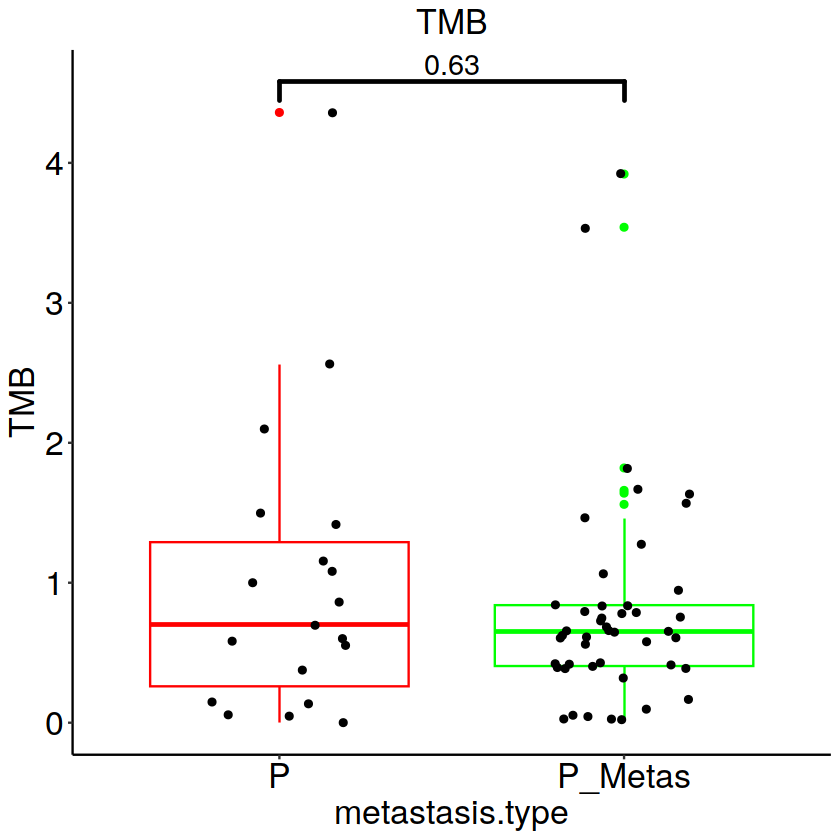

In [293]:

maf_P = maf_all[maf_all$Tumors.for.scRNA.seq.short=="P" & maf_all$histological.type.short=="adeno",]
maf_P = maf_P[maf_P$total<1000,]
# maf_P$metastasis.type[maf_P$metastasis.type=="P_LI"] = "P"
# maf_P$metastasis.type = factor(maf_P$metastasis.type,levels = c("P","P_LN","P_LM"))
library(ggpubr)
text_size = 20
# png("./summary/figures/TMB.png")
ggplot(maf_P,aes(x = metastasis.type,y = TMB))+geom_boxplot(color = c("red","green"))+ stat_compare_means(comparisons = list(
  c("P","P_Metas")
),method = "wilcox.test",bracket.size = 1,size = 6)+ggtitle("TMB")+geom_jitter(width=0.2)+
  theme(panel.grid.major = element_blank(),panel.grid.minor = element_blank(),panel.background = element_blank(), 
                                               axis.line = element_line(colour = "black"),
                                               legend.position = "none",
                                               axis.text.x = element_text(color="black", size=text_size),
                                               axis.text.y = element_text(color="black", size=text_size),
                                               axis.title=element_text(size=text_size),
                                               legend.text=element_text(size=text_size),
                                               legend.title=element_text(size=text_size),
                                               plot.title =element_text(hjust = 0.5, size = 20))
# dev.off()



In [294]:
maf = maf_all[maf_all$total<1000,]

In [1274]:
ggplot_list = list()

In [1275]:
# maf$Clinical.stage = factor(maf$Clinical.stage,c("I","II","IIIA","IIIB","IVA","IVB"))
ggplot_list[[1]] = ggboxplot(maf_all, x = "Clinical.stage", y = "TMB",
               color = "Clinical.stage", palette = "jco",add = "jitter")+
stat_compare_means(method = "anova")+theme(axis.title.x = element_blank())+theme(legend.position="none")


In [1276]:

ggplot_list[[2]] = ggboxplot(maf_all, x = "Tumors.for.scRNA.seq.short", y = "TMB",
               color = "Tumors.for.scRNA.seq.short", palette = "jco",add = "jitter")+
stat_compare_means(method = "anova")+theme(axis.title.x = element_blank())+theme(legend.position="none")


In [307]:
ggplot_list[[3]] = ggboxplot(maf_all, x = "Clinical.stage", y = "cnv_count",
               color = "Clinical.stage", palette = "jco",add = "jitter")+
stat_compare_means(method = "anova")+theme(axis.title.x = element_blank())+theme(legend.position="none")


In [308]:
ggplot_list[[4]] = ggboxplot(maf_all, x = "Tumors.for.scRNA.seq.short", y = "cnv_count",
               color = "Tumors.for.scRNA.seq.short", palette = "jco",add = "jitter")+
stat_compare_means(method = "anova")+theme(axis.title.x = element_blank())+theme(legend.position="none")


In [1279]:
pdf("./figures/TMB_cnv_count.pdf",height = 4,width = 8)
ggplot_list[[1]]+ggplot_list[[2]]
dev.off()

png 
  2

## 2.compare pair sample mutation

In [12]:
onco_matrix_all = read.csv("./onco_matrix_105_patient.csv",row.names = 1)
# onco_matrix_filter = read.csv("./onco_matrix_filter.csv",row.names = 1)

In [13]:
patient_LI_info = data.frame("Pair" = colnames(onco_matrix_all)[grepl(pattern = "LI",colnames(onco_matrix_all))])
patient_LI_info$Primary = apply(patient_LI_info,FUN = function(i){paste0(substr(i, 1, nchar(i) - 2), "P")},MARGIN = 1)

patient_LM_info = data.frame("Pair" = colnames(onco_matrix_all)[grepl(pattern = "LM",colnames(onco_matrix_all))])
patient_LM_info$Primary = apply(patient_LM_info,FUN = function(i){paste0(substr(i, 1, nchar(i) - 2), "P")},MARGIN = 1)

patient_LN_info = data.frame("Pair" = colnames(onco_matrix_all)[grepl(pattern = "LN",colnames(onco_matrix_all))])
patient_LN_info$Primary = apply(patient_LN_info,FUN = function(i){paste0(substr(i, 1, nchar(i) - 2), "P")},MARGIN = 1)

patient_OM_info = data.frame("Pair" = colnames(onco_matrix_all)[grepl(pattern = "OM",colnames(onco_matrix_all))])
patient_OM_info$Primary = apply(patient_OM_info,FUN = function(i){paste0(substr(i, 1, nchar(i) - 2), "P")},MARGIN = 1)

patient_PO_info = data.frame("Pair" = colnames(onco_matrix_all)[grepl(pattern = "PO",colnames(onco_matrix_all))])
patient_PO_info$Primary = apply(patient_PO_info,FUN = function(i){paste0(substr(i, 1, nchar(i) - 2), "P")},MARGIN = 1)

In [14]:
all_pair_sample = rbind(patient_LI_info,patient_LM_info,patient_LN_info,patient_OM_info,patient_PO_info)
all_pair_sample = all_pair_sample[all_pair_sample[,1] %in% colnames(onco_matrix_all) & all_pair_sample[,2] %in% colnames(onco_matrix_all),]

In [15]:
patient_list = list()
for(ipatient in all_pair_sample$Primary){
    patient_list[[ipatient]] = all_pair_sample[all_pair_sample$Primary==ipatient,"Pair"]
}

In [18]:
onco_matrix_all_pair = onco_matrix_all[,unique(c(all_pair_sample[,1],all_pair_sample[,2]))]
dim(onco_matrix_all_pair)

[1] 3554   48

In [19]:

library(dplyr)

df <- onco_matrix_all_pair

column_combinations <- combn(colnames(df), 2) 

combinations_df <- data.frame(t(column_combinations))

jaccard_matrix <- matrix(nrow = ncol(df), ncol = ncol(df))
colnames(jaccard_matrix) <- rownames(jaccard_matrix) <- colnames(df)

for (i in 1:ncol(column_combinations)) {
  col1 <- column_combinations[1, i]
  gene1 = rownames(df)[df[, col1]!=""]
  col2 <- column_combinations[2, i]
  gene2 = rownames(df)[df[, col2]!=""]
  jaccard_matrix[col1, col2] <- length(intersect(gene1,gene2)) / length(union(gene1,gene2))
  jaccard_matrix[col2, col1] <- jaccard_matrix[col1, col2]
}

jaccard_matrix = as.data.frame(jaccard_matrix)
head(jaccard_matrix)

,GBC_074_LI,GBC_069_LI,GBC_010_LI,GBC_025_LI,GBC_012_LI,GBC_058_LI,GBC_036_LI,GBC_017_LI,GBC_042_LI,GBC_077_LM,⋯,GBC_040_P,GBC_078_P,GBC_071_P,GBC_063_P,GBC_046_P,GBC_056_P,GBC_067_P,GBC_028_P,GBC_008_P,GBC_047_P
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GBC_074_LI,NA,0.01111111,0.01315789,0.02666667,0.01587302,0,0.000000000,0,0.000000000,0.02564103,⋯,0.02816901,0.005333333,0.02597403,0.012987013,0.014084507,0.007692308,0.01369863,0.00000000,0,0
GBC_069_LI,0.01111111,NA,0.04109589,0.01333333,0.05000000,0,0.000000000,0,0.000000000,0.02597403,⋯,0.01408451,0.005347594,0.01298701,0.000000000,0.000000000,0.000000000,0.00000000,0.01190476,0,0
GBC_010_LI,0.01315789,0.04109589,NA,0.03333333,0.04255319,0,0.034482759,0,0.014705882,0.03174603,⋯,0.01754386,0.005555556,0.01587302,0.000000000,0.017857143,0.000000000,0.00000000,0.00000000,0,0
GBC_025_LI,0.02666667,0.01333333,0.03333333,NA,0.02083333,0,0.000000000,0,0.014705882,0.01562500,⋯,0.01754386,0.008356546,0.03225806,0.000000000,0.000000000,0.000000000,0.00000000,0.00000000,0,0
GBC_012_LI,0.01587302,0.05000000,0.04255319,0.02083333,NA,0,0.000000000,0,0.000000000,0.04000000,⋯,0.02272727,0.002873563,0.02000000,0.000000000,0.000000000,0.000000000,0.02222222,0.00000000,0,0
GBC_058_LI,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,NA,0.007751938,0,0.007246377,0.00000000,⋯,0.00000000,0.014084507,0.00000000,0.007575758,0.007936508,0.010869565,0.01574803,0.00000000,0,0


In [20]:
library(VennDiagram)

Loading required package: grid

Loading required package: futile.logger



In [21]:
samples = c("GBC_042_P","GBC_058_P","GBC_069_P","GBC_074_P")

In [22]:
library(VennDiagram)
for(isample in samples){
    print(isample)
    gene_1 = rownames(onco_matrix_all)[onco_matrix_all[,patient_list[[isample]][1]]!=""]
    print("TP53" %in% gene_1)
    gene_2 = rownames(onco_matrix_all)[onco_matrix_all[,patient_list[[isample]][2]]!=""]
    print("TP53" %in% gene_2)
    
}

[1] "GBC_042_P"
[1] FALSE
[1] FALSE
[1] "GBC_058_P"
[1] FALSE
[1] FALSE
[1] "GBC_069_P"
[1] TRUE
[1] TRUE
[1] "GBC_074_P"
[1] TRUE
[1] TRUE


In [552]:
library(VennDiagram)
for(isample in samples){
    gene_1 = rownames(onco_matrix_all)[onco_matrix_all[,patient_list[[isample]][1]]!=""]
    # print(gene_1)
    gene_2 = rownames(onco_matrix_all)[onco_matrix_all[,patient_list[[isample]][2]]!=""]
    gene_3 = rownames(onco_matrix_all)[onco_matrix_all[,isample]!=""]
    # print(gene_2)
    venn.diagram(x=list(HRG=gene_1,HVG = gene_2,HRG2 = gene_3), category.names = c(patient_list[[isample]][1],patient_list[[isample]][2],isample),fill=c("#FC8D62", "#8DA0CB","red"),
             filename = paste0('./figures/pair_sample/venn_',isample,'.tiff'),cat.cex = 2,cex = 2,cat.pos = c(-20,20,180))
}

In [25]:
data_plot = as.data.frame(t(as.data.frame(patient_list[samples])))
data_plot$jaccard = 0
for(isample in samples){
    data_plot[isample,"jaccard"] = jaccard_matrix[patient_list[[isample]][1],patient_list[[isample]][2]]
    print(jaccard_matrix[c(patient_list[[isample]],isample),c(patient_list[[isample]],isample)])
}

           GBC_042_LI GBC_042_LM GBC_042_P
GBC_042_LI         NA  0.4909091 0.3026316
GBC_042_LM  0.4909091         NA 0.3815789
GBC_042_P   0.3026316  0.3815789        NA
           GBC_058_LI GBC_058_LN  GBC_058_P
GBC_058_LI         NA 0.01869159 0.67924528
GBC_058_LN 0.01869159         NA 0.02409639
GBC_058_P  0.67924528 0.02409639         NA
           GBC_069_LI GBC_069_LM GBC_069_P
GBC_069_LI         NA  0.3750000 0.3977273
GBC_069_LM  0.3750000         NA 0.5714286
GBC_069_P   0.3977273  0.5714286        NA
           GBC_074_LI GBC_074_LN GBC_074_P
GBC_074_LI         NA  0.6000000 0.6111111
GBC_074_LN  0.6000000         NA 0.5961538
GBC_074_P   0.6111111  0.5961538        NA


In [554]:
data_plot$group = "GBC cancer"
pdf("./figures/pair_sample/jaccard_index.pdf",height = 4,width = 3)
ggplot(data_plot,aes(x = group,y = jaccard,fill = group))+geom_boxplot()+geom_jitter()+theme_bw()+ylab("Jaccard similarity coefficient")+
theme(legend.position = "none")+scale_fill_manual(values = c("#FC8D62"))
dev.off()

png 
  2

In [555]:
data_plot$group = "GBC cancer"
pdf("./figures/pair_sample/jaccard_indexV2.pdf",height = 3,width = 4)
ggplot(data_plot,aes(y = group,x = jaccard,fill = group))+geom_boxplot()+geom_jitter()+theme_bw()+xlab("Jaccard similarity coefficient")+
theme(legend.position = "none")+scale_fill_manual(values = c("#FC8D62"))
dev.off()

png 
  2

In [28]:
all_pair_sample$jaccard = 0
for(i in 1:nrow(all_pair_sample)){
    # print(i)
    all_pair_sample[i,"jaccard"] = jaccard_matrix[all_pair_sample[i,1],all_pair_sample[i,2]]
}
all_pair_sample$type = "Pair"

In [29]:
data_plot = rbind(all_pair_sample)

In [41]:
median(data_plot[1:24,"jaccard"])

[1] 0.5227704

In [60]:
library(ggplot2)
library(ggpubr)
pdf("./figures/pair_sample_similarity20250318.pdf",height = 4,width = 4)
# options(repr.plot.width = 6, repr.plot.height =5)
ggplot(data_plot[1:24,],aes(x = type,y = jaccard,fill = type))+geom_boxplot()+geom_point()+theme_bw()+theme(legend.position = "none")+ylab("Jaccard similarity
 coefficient")+xlab("Paired sample")
dev.off()

png 
  2

### driver gene

In [1280]:
mutSigCV = read.csv("/home/wyh/scdata/WES_V2/MutSig/ans/GBC_MutSig.sig_genes_Hugo_Symbol.txt",sep = "")

In [1282]:
driver_gene = mutSigCV$gene[mutSigCV$p<0.05]

In [1284]:
library(dplyr)
df <- onco_matrix_all_pair

jaccard_matrix <- matrix(nrow = ncol(df), ncol = ncol(df))
colnames(jaccard_matrix) <- rownames(jaccard_matrix) <- colnames(df)

for (i in 1:ncol(column_combinations)) {
  col1 <- column_combinations[1, i]
  gene1 = rownames(df)[df[, col1]!=""]
  gene1 = gene1[gene1 %in% driver_gene]
  col2 <- column_combinations[2, i]
  gene2 = rownames(df)[df[, col2]!=""]
  gene2 = gene2[gene2 %in% driver_gene]  
  jaccard_matrix[col1, col2] <- length(intersect(gene1,gene2)) / length(union(gene1,gene2))
  jaccard_matrix[col2, col1] <- jaccard_matrix[col1, col2]
}

jaccard_matrix = as.data.frame(jaccard_matrix)
head(jaccard_matrix)

,GBC_074_LI,GBC_069_LI,GBC_010_LI,GBC_025_LI,GBC_012_LI,GBC_058_LI,GBC_036_LI,GBC_017_LI,GBC_042_LI,GBC_077_LM,⋯,GBC_040_P,GBC_078_P,GBC_071_P,GBC_063_P,GBC_046_P,GBC_056_P,GBC_067_P,GBC_028_P,GBC_008_P,GBC_047_P
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GBC_074_LI,NA,0.0500000,0.06666667,0.14285714,0.06666667,0,0.0000000,0,0.00000000,0.07692308,⋯,0.07142857,0.04761905,0.10000000,0,0,0,0.0000000,0,0,0
GBC_069_LI,0.05000000,NA,0.21428571,0.06250000,0.13333333,0,0.0000000,0,0.00000000,0.15384615,⋯,0.06666667,0.02272727,0.04545455,0,0,0,0.0000000,0,0,0
GBC_010_LI,0.06666667,0.2142857,NA,0.20000000,0.20000000,0,0.1428571,0,0.06666667,0.25000000,⋯,0.10000000,0.02564103,0.05882353,0,0,0,0.0000000,0,0,0
GBC_025_LI,0.14285714,0.0625000,0.20000000,NA,0.09090909,0,0.0000000,0,0.06666667,0.11111111,⋯,0.10000000,0.02564103,0.12500000,0,0,0,0.0000000,0,0,0
GBC_012_LI,0.06666667,0.1333333,0.20000000,0.09090909,NA,0,0.0000000,0,0.00000000,0.25000000,⋯,0.10000000,0.02564103,0.05882353,0,0,0,0.1111111,0,0,0
GBC_058_LI,0.00000000,0.0000000,0.00000000,0.00000000,0.00000000,NA,0.0000000,0,0.00000000,0.00000000,⋯,0.00000000,0.00000000,0.00000000,0,0,0,0.0000000,0,0,0


In [1290]:
onco_matrix_all_pair = onco_matrix_all[,unique(c(all_pair_sample[,1],all_pair_sample[,2]))]
dim(onco_matrix_all_pair)

[1] 3554   48

In [1291]:
library(VennDiagram)

In [1292]:
samples = c("GBC_042_P","GBC_058_P","GBC_069_P","GBC_074_P")

In [1293]:
library(VennDiagram)
for(isample in samples){
    gene_1 = rownames(onco_matrix_all)[onco_matrix_all[,patient_list[[isample]][1]]!=""]
    gene_1 = gene_1[gene_1 %in% driver_gene]
    # print(gene_1)
    gene_2 = rownames(onco_matrix_all)[onco_matrix_all[,patient_list[[isample]][2]]!=""]
    gene_2 = gene_2[gene_2 %in% driver_gene]
    gene_3 = rownames(onco_matrix_all)[onco_matrix_all[,isample]!=""]
    gene_3 = gene_3[gene_3 %in% driver_gene]
    # print(gene_2)
    venn.diagram(x=list(HRG=gene_1,HVG = gene_2,HRG2 = gene_3), category.names = c(patient_list[[isample]][1],patient_list[[isample]][2],isample),fill=c("#FC8D62", "#8DA0CB","red"),
             filename = paste0('./figures/pair_sample/venn_',isample,'V2.tiff'),cat.cex = 2,cex = 2,cat.pos = c(-20,20,180))
}

In [1294]:
data_plot = as.data.frame(t(as.data.frame(patient_list[samples])))
data_plot$jaccard = 0
for(isample in samples){
    data_plot[isample,"jaccard"] = jaccard_matrix[patient_list[[isample]][1],patient_list[[isample]][2]]
    print(jaccard_matrix[c(patient_list[[isample]],isample),c(patient_list[[isample]],isample)])
}

           GBC_042_LI GBC_042_LM GBC_042_P
GBC_042_LI         NA  0.8181818 0.3333333
GBC_042_LM  0.8181818         NA 0.4000000
GBC_042_P   0.3333333  0.4000000        NA
           GBC_058_LI GBC_058_LN GBC_058_P
GBC_058_LI         NA          0 0.9166667
GBC_058_LN  0.0000000         NA 0.0000000
GBC_058_P   0.9166667          0        NA
           GBC_069_LI GBC_069_LM GBC_069_P
GBC_069_LI         NA  0.5789474 0.6111111
GBC_069_LM  0.5789474         NA 0.9473684
GBC_069_P   0.6111111  0.9473684        NA
           GBC_074_LI GBC_074_LN GBC_074_P
GBC_074_LI         NA  0.6666667 0.9000000
GBC_074_LN  0.6666667         NA 0.7272727
GBC_074_P   0.9000000  0.7272727        NA


In [1295]:
data_plot$group = "GBC cancer"
pdf("./figures/pair_sample/jaccard_index_driver_mutation.pdf",height = 3,width = 4)
ggplot(data_plot,aes(y = group,x = jaccard,fill = group))+geom_boxplot()+geom_jitter()+theme_bw()+xlab("Jaccard similarity coefficient")+
theme(legend.position = "none")+scale_fill_manual(values = c("#FC8D62"))
dev.off()

png 
  2

In [1296]:
all_pair_sample$jaccard_driver_gene = 0
for(i in 1:nrow(all_pair_sample)){
    # print(i)
    all_pair_sample[i,"jaccard_driver_gene"] = jaccard_matrix[all_pair_sample[i,1],all_pair_sample[i,2]]
}
all_pair_sample$type = "Pair"

In [1297]:
data_plot = rbind(all_pair_sample)

In [1298]:
library(ggplot2)
library(ggpubr)
pdf("./figures/pair_sample_similarity_driver_mutation.pdf",height = 4,width = 4)
# options(repr.plot.width = 6, repr.plot.height =5)
ggplot(data_plot,aes(x = type,y = jaccard_driver_gene,fill = type))+geom_boxplot()+theme_bw()+theme(legend.position = "none")
dev.off()

Warning message:
“Removed 1 rows containing non-finite values (`stat_boxplot()`).”


png 
  2

### cancer discovery

In [266]:
laml_filter = readRDS("laml_filter_20_3_0015_005.RDS")

In [576]:
## analyze VAF shift

In [283]:
laml_filter@data$AF = apply(as.data.frame(laml_filter@data[,'Otherinfo13']),FUN = function(i){strsplit(as.character(i),":")[[1]][3]},MARGIN = 1)

In [1]:
mutSigCV = read.csv("/home/wyh/scdata/WES_V2/MutSig/ans/GBC_MutSig.sig_genes.txt",sep = "")

In [2]:
driver_gene_P = mutSigCV$gene[mutSigCV$p<0.05]
length(driver_gene_P)

[1] 238

In [580]:
## laml_filter@maf.silent
mut_table = rbind(laml_filter@data)

In [581]:
mut_table =as.data.frame(mut_table)

In [582]:
all_pair_sample$compare_all_gene = "NA"
all_pair_sample$common_gene_num = "NA"
all_pair_sample$pvalue_all_gene = "NA"

In [583]:
for(i in 1:nrow(all_pair_sample)){
    Primary = mut_table[mut_table[,'Tumor_Sample_Barcode']==all_pair_sample[i,2],c("Chromosome","Start_Position","End_Position","Reference_Allele","Hugo_Symbol",'AF')]
    rownames(Primary) = apply(Primary[, 1:5], 1, paste0, collapse = "_")
    # print(all_pair_sample[i,2])
    Mets = mut_table[mut_table[,'Tumor_Sample_Barcode']==all_pair_sample[i,1],c("Chromosome","Start_Position","End_Position","Reference_Allele","Hugo_Symbol",'AF')]
    rownames(Mets) = apply(Mets[, 1:5], 1, paste0, collapse = "_")
    # print(Mets)
    common_genes = intersect(rownames(Primary),rownames(Mets))
    # print(length(common_genes))
    if(length(common_genes)>0){
        all_pair_sample[i,"common_gene_num"] = length(common_genes)
        combined = Primary[common_genes,]
        combined$Met_AF = Mets[common_genes,"AF"]
        # print(combined)
        # print(length(common_genes))
        data_plot = combined[,5:ncol(combined)]
        data_plot = melt(data_plot,id.vars = "Hugo_Symbol")
        data_plot$value = as.numeric(data_plot$value)
        results <- compare_means(value ~ variable, data = data_plot, method = "t.test", paired = TRUE)
        # t test
        test_result <- t.test(value ~ variable, data = data_plot, paired = TRUE)


        # mean and pvalue
        mean_cancer <- mean(data_plot$value[data_plot$variable == "Met_AF"])
        mean_control <- mean(data_plot$value[data_plot$variable == "AF"])
        p_value <- test_result$p.value
        all_pair_sample[i,"pvalue_all_gene"] = p_value

        
        if (p_value < 0.05) { 
          if (mean_cancer > mean_control) {
            result <- "higher"
          } else {
            result <- "lower"
          }
        } else {
          result <- "equal"
        }
        all_pair_sample[i,"compare_all_gene"] = result  
    }
    
}

In [616]:
write.csv(all_pair_sample,"./pair_sample_wes/all_pair_sample.csv")

## 3.CADD

In [1194]:
library(data.table)


vcf_file <- "/home/wyh/scdata/WES_V2/annovar_merge_20_3_0015_005_rename.vcf"
vcf_data_all <- fread(vcf_file)

vcf_data = vcf_data_all[,c(1:5)]
colnames(vcf_data) = c("CHROM","POS","End","Ref","Alt")
fwrite(vcf_data, "/home/wyh/scdata/WES_V2/CADD/annovar_merge_20_3_0015_005_CADD.vcf", sep = "\t")

annovar_merge_20_3_0015_005_CADD.vcf input to ：https://cadd.bihealth.org/score

In [1196]:
CADD_df = read.table("./CADD/GRCh38-v1.7.tsv",sep = "\t")
colnames(CADD_df) = c("CHROM","POS","Ref","Alt","RawScore","PHRED")

In [1197]:
CADD_df = CADD_df[!duplicated(CADD_df),]

In [1198]:
names = c()
for(i in c(1:nrow(CADD_df))){
    names = c(names,paste0("chr",CADD_df[i,1],"_",CADD_df[i,2],"_",CADD_df[i,3],"_",CADD_df[i,4]))
}
CADD_df$names = names
rownames(CADD_df) = CADD_df$names

In [1413]:
laml_filter = readRDS("laml_filter_20_3_0015_005.RDS")
vcf_data_all = rbind(laml_filter@data,laml_filter@maf.silent)

In [1414]:
names = c()
for(i in c(1:nrow(vcf_data_all))){
    names = c(names,paste0(vcf_data_all[i,1],"_",vcf_data_all[i,2],"_",vcf_data_all[i,4],"_",vcf_data_all[i,5]))
}
vcf_data_all$names = names

In [1415]:
vcf_data_all$RawScore = CADD_df[vcf_data_all$names,"RawScore"]
vcf_data_all$PHRED = CADD_df[vcf_data_all$names,"PHRED"]

In [1203]:
fwrite(vcf_data_all, paste0("/home/wyh/scdata/WES_V2/CADD/Wes_20_3_0015_005_CADD_result.vcf"), sep = "\t")

In [1416]:
vcf_data_all_temp = vcf_data_all[!vcf_data_all$Tumor_Sample_Barcode %in% hyper_sample,]

In [1418]:
fwrite(vcf_data_all_temp, paste0("/home/wyh/scdata/WES_V2/CADD/Wes_20_3_0015_005_CADD_result_remove_hyper_samples.vcf"), sep = "\t")

# TMB and cnv count comparison

In [1269]:
maf_all = read.csv("./summary/wes_info.csv",row.names = 1)

In [1270]:
patient_info = read.csv("../patient_info/xzh_220109_final_wyh_220426.csv",row.names = 1)
patient_info$metastasis.type[patient_info$metastasis.type=="P_LI"] = "P"
patient_info$metastasis.type[patient_info$metastasis.type %in% c("P_LN","P_LM")] = "P_Metas"
patient_info$metastasis.type = as.character(patient_info$metastasis.type)
# patient_info$metastasis.type = factor(patient_info$metastasis.type,levels = c("P","P_LN","P_LM"))

patient_info$Clinical.stage[patient_info$Clinical.stage %in% c("IIA","IIB")] = "II"
patient_info$Clinical.stage = factor(patient_info$Clinical.stage,levels = c("I","II","IIIA","IIIB","IVA","IVB"))

patient_info$Tumors.for.scRNA.seq.short = factor(patient_info$Tumors.for.scRNA.seq.short,levels = c("P","PO","LN","LI","LM","OM"))

In [1271]:
maf_all$NewSample.ID = maf_all$Tumor_Sample_Barcode
maf_all = merge(maf_all,patient_info)

In [1274]:
ggplot_list = list()

In [1275]:

# maf$Clinical.stage = factor(maf$Clinical.stage,c("I","II","IIIA","IIIB","IVA","IVB"))
ggplot_list[[1]] = ggboxplot(maf_all, x = "Clinical.stage", y = "TMB",
               color = "Clinical.stage", palette = "jco",add = "jitter")+
stat_compare_means(method = "anova")+theme(axis.title.x = element_blank())+theme(legend.position="none")


In [1276]:

ggplot_list[[2]] = ggboxplot(maf_all, x = "Tumors.for.scRNA.seq.short", y = "TMB",
               color = "Tumors.for.scRNA.seq.short", palette = "jco",add = "jitter")+
stat_compare_means(method = "anova")+theme(axis.title.x = element_blank())+theme(legend.position="none")


In [307]:
ggplot_list[[3]] = ggboxplot(maf_all, x = "Clinical.stage", y = "cnv_count",
               color = "Clinical.stage", palette = "jco",add = "jitter")+
stat_compare_means(method = "anova")+theme(axis.title.x = element_blank())+theme(legend.position="none")


In [308]:
ggplot_list[[4]] = ggboxplot(maf_all, x = "Tumors.for.scRNA.seq.short", y = "cnv_count",
               color = "Tumors.for.scRNA.seq.short", palette = "jco",add = "jitter")+
stat_compare_means(method = "anova")+theme(axis.title.x = element_blank())+theme(legend.position="none")


In [1279]:
pdf("./figures/TMB_cnv_count.pdf",height = 4,width = 8)
ggplot_list[[1]]+ggplot_list[[2]]
dev.off()

png 
  2

### mutation rate between samples with different GM ratios

In [1304]:
library(ggplot2)

In [191]:
# matMut <- read.table("onco_matrix_P0725.txt", header = T, check.names = F, sep = "\t")

In [1350]:
matMut = read.csv("./onco_matrix_105_patient.csv",row.names = 1)
matMut[,'GBC_002_P'] = ''

In [1352]:
patient_intersect = intersect(colnames(matMut),rownames(sample_data))
matMut = matMut[,patient_intersect]

In [1354]:
sample_data = read.csv("/home/wyh/scdata/combined_data/Epithelial//submit/figure_data/heatmap_GM_score.csv",row.names = 1)
sample_info =  data.frame(sample_name = colnames(matMut),row.names = colnames(matMut))

In [1322]:
# matMut <- read.table("onco_matrix_P0725.txt", header = T, check.names = F, sep = "\t")
# matMut$GBC_032_P = ""
matMut[matMut!=""] = 1
matMut[matMut==""] = 0

matMut_df = data.frame(matrix(ncol = 4, nrow = 0))
colnames(matMut_df) = c("gene","sample","value","metastasis.type")
iindex = 1
for(i in 1:nrow(matMut)){
  for(j in 1:ncol(matMut)){
    matMut_df[iindex,] = c(rownames(matMut)[i],colnames(matMut)[j],matMut[i,j],as.character(patient_info[colnames(matMut)[j],"metastasis.type"]))
    iindex = iindex + 1
  }
}
patient_num = as.data.frame.array(table(patient_info[colnames(matMut),"metastasis.type"]))[,1]
matMut_df = matMut_df[matMut_df$value==1,]

In [1358]:
matMut[matMut!=""] = 1
matMut[matMut==""] = 0
matMut$gene = rownames(matMut)
matMut_df = melt(matMut,id.vars = "gene",variable.name = "sample")
matMut_df['metastasis.type'] = patient_info[matMut_df[,"sample"],"metastasis.type"]

In [1369]:
matMut_df = matMut_df[matMut_df$value==1,]

In [353]:
# Italics P 
# https://www.r-bloggers.com/2018/03/math-notation-for-r-plot-titles-expression-and-bquote/\
# https://www.statology.org/italics-in-r/

In [1370]:
for(iGM in c(1,3,5,6,7,8,16)){
    sample_info['GM16_score'] = sample_data[sample_info$sample_name,paste0('score_GM',iGM)]
    sample_info['GM16_ratio'] = ifelse(sample_info[,"GM16_score"] >= median(sample_info[,"GM16_score"]),'High','Low')
    #sample_info['GM16_ratio'] = ifelse(sample_info[,"GM16_score"] >= quantile(sample_info[,"GM16_score"],2/3),'High','Median')
    #sample_info[sample_info[,"GM16_score"] <= quantile(sample_info[,"GM16_score"],1/3),'GM16_ratio'] = 'Low'
    patient_num = as.data.frame.array(table(sample_info$GM16_ratio))

    matMut_df = matMut_df[matMut_df$value==1,]
    matMut_df$GM16_ratio = sample_info[matMut_df$sample,"GM16_ratio"]
    #matMut_df = matMut_df[matMut_df$GM16_ratio!="Median",]
    GM16_mutation = as.data.frame.array(table(matMut_df[,c("gene","GM16_ratio")]))
    GM16_mutation$Low_ratio = round(GM16_mutation$Low/(patient_num[2,1]),3)
    GM16_mutation$Low_ratio_text = paste0(GM16_mutation$Low,"/",patient_num[2,1])
    GM16_mutation$High_ratio = round(GM16_mutation$High/patient_num[1,1],3)
    GM16_mutation$High_ratio_text = paste0(GM16_mutation$High,"/",patient_num[1,1])

    GM16_mutation$pvalue_greater = 0
    GM16_mutation$pvalue_less = 0
    GM16_mutation$pvalue = 0
    # patient_num = as.data.frame.array(table(sample_info$GM16_ratio))
    for(igene in rownames(GM16_mutation)){
      gene_matrix = matrix(c(GM16_mutation[igene,1],GM16_mutation[igene,2],patient_num[1,1]-GM16_mutation[igene,1],patient_num[2,1]-GM16_mutation[igene,2]),nrow = 2,
                           dimnames = list(c("High","Low"),c("mutate","Non-mutate")))
      gene_matrix = t(gene_matrix)
      GM16_mutation[igene,"pvalue_greater"] = round(fisher.test(gene_matrix,alternative = "greater")$p.value,3)
      GM16_mutation[igene,"pvalue_less"] = round(fisher.test(gene_matrix,alternative = "less")$p.value,3)
      GM16_mutation[igene,"pvalue"] = round(fisher.test(gene_matrix)$p.value,3)
    }

    gene_plot = rownames(GM16_mutation[order(GM16_mutation$pvalue),])[GM16_mutation[order(GM16_mutation$pvalue),]$pvalue<0.05]
    print(length(gene_plot))
    if(length(gene_plot)>0){
     pdf(paste0("./figures/GM",iGM,"_mutation.pdf"),height = 3.7,width = 2)
    for(igene in gene_plot){
        data_plot = data.frame(freq = t(GM16_mutation[igene,c('Low_ratio',"High_ratio")]),name = c("Low","High"))
        data_plot$por = t(GM16_mutation[igene,c("Low_ratio_text","High_ratio_text")])
        colnames(data_plot) = c("ratio","name","por_text")
        data_plot$name = factor(data_plot$name,levels = c("Low","High"))
        p<-ggplot(data=data_plot, aes(x=name, y=ratio)) +
        geom_bar(stat="identity", fill="steelblue")+
        theme_minimal()+geom_text(aes(label=por_text), vjust=-0.3, size=3.5)+theme_classic()+
        ggtitle(igene,subtitle = paste('P' , "= ", GM16_mutation[igene,"pvalue"]))+xlab(paste0("GM",iGM,"_score"))+ylab("Mutational Frequency")+
        theme(plot.title = element_text(hjust = 0.5))
    print(p)
    }
    dev.off()   
    }
  
}

[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 1


In [1378]:
sample_wes = read.csv("./summary/wes_info.csv",row.names = 1)

In [1379]:
sample_data = read.csv("/home/wyh/scdata/combined_data/Epithelial/submit/figure_data/heatmap_GM_score.csv",row.names = 1)

In [1380]:
common_patient = intersect(rownames(sample_data),rownames(sample_wes))

In [1381]:
sample_info =  data.frame(sample_name = rownames(sample_data),row.names = rownames(sample_data))

sample_info['GM16_score'] = sample_data[sample_info$sample_name,'score_GM16']
sample_info = sample_info[common_patient,]
# sample_info['GM16_ratio'] = ifelse(sample_info[,"GM16_score"] >= median(sample_info[,"GM16_score"]),'High','Low')

In [1382]:
sample_info$TMB = sample_wes[rownames(sample_info),"TMB"]
sample_info$metastasis.type = patient_info[rownames(sample_info),"metastasis.type"]
sample_info$progression.type.short = patient_info[rownames(sample_info),"progression.type.short"]

In [1383]:
sample_info$metastasis.type[sample_info$metastasis.type=="P_LI"] = "P"
sample_info$metastasis.type[sample_info$metastasis.type %in% c("P_LN","P_LM")] = "P_Metas"

Warning message in wilcox.test.default(c(0.66, 0.06, 0.4, 0.4, 3.28, 0.32, 0.38, :
“cannot compute exact p-value with ties”


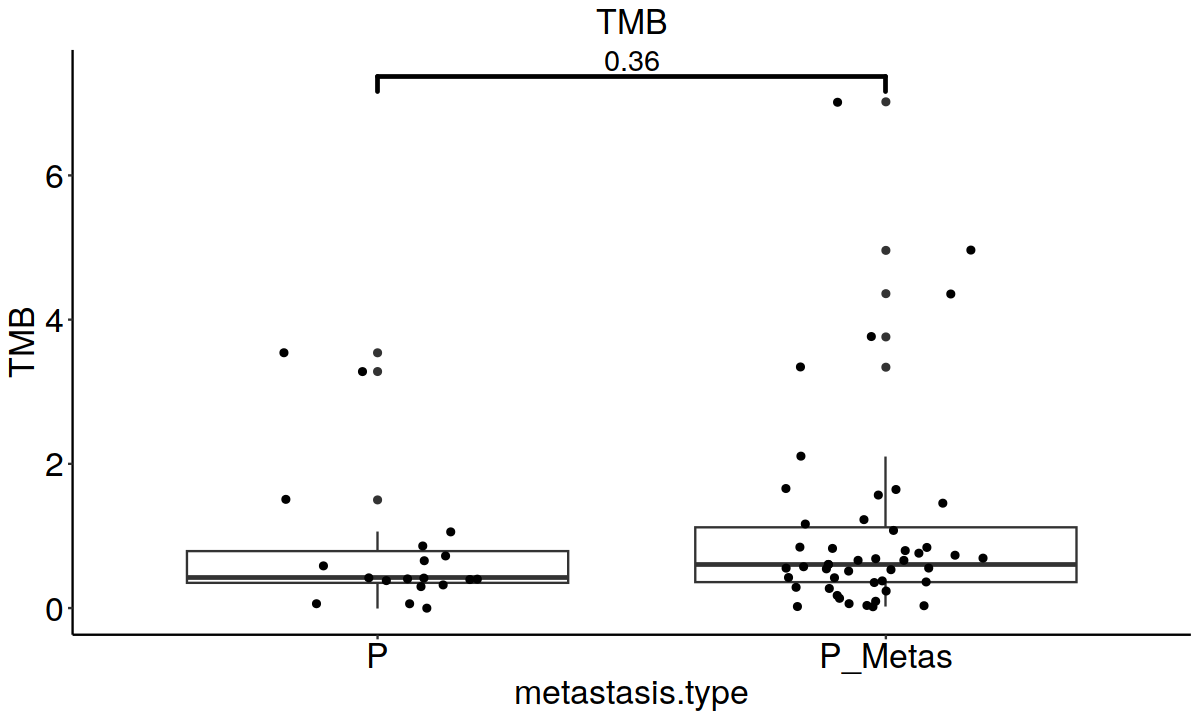

In [ ]:
text_size = 20
ggplot(sample_info,aes(x = metastasis.type,y = TMB))+geom_boxplot()+ stat_compare_means(comparisons = list(
  c("P",'P_Metas')
),method = "wilcox.test",bracket.size = 1,size = 6)+ggtitle("TMB")+geom_jitter(width=0.2)+
  theme(panel.grid.major = element_blank(),panel.grid.minor = element_blank(),panel.background = element_blank(), 
                                               axis.line = element_line(colour = "black"),
                                               legend.position = "none",
                                               axis.text.x = element_text(color="black", size=text_size),
                                               axis.text.y = element_text(color="black", size=text_size),
                                               axis.title=element_text(size=text_size),
                                               legend.text=element_text(size=text_size),
                                               legend.title=element_text(size=text_size),
                                               plot.title =element_text(hjust = 0.5, size = 20))

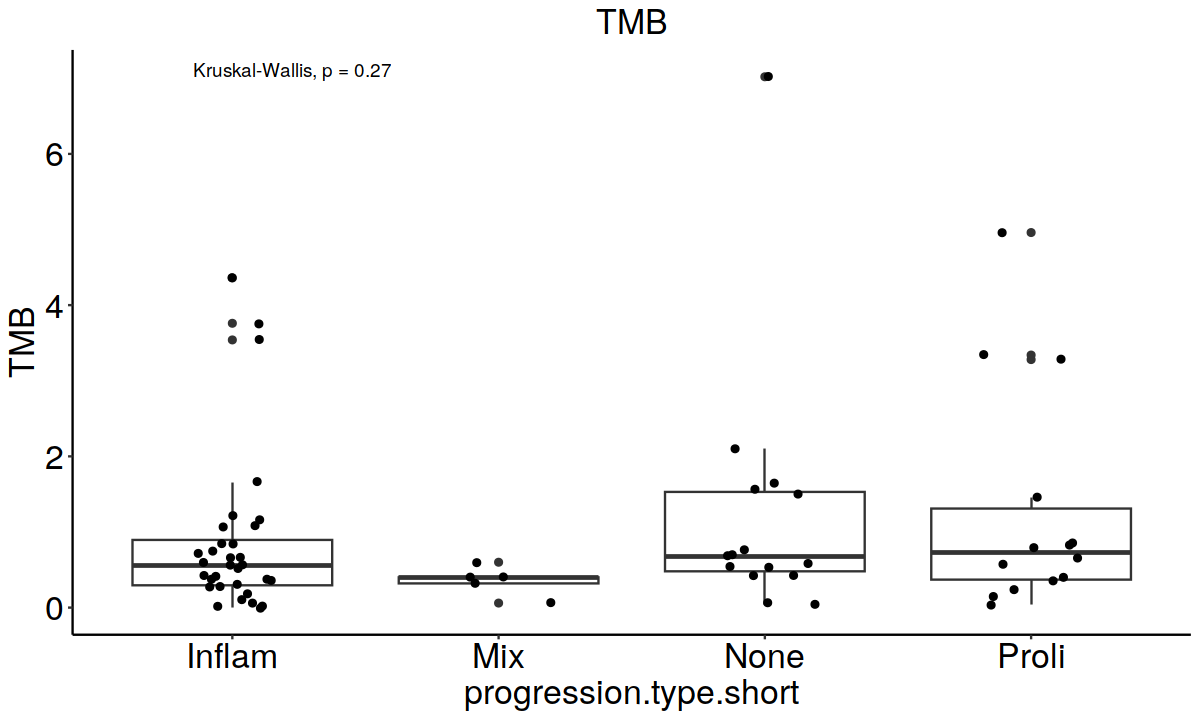

In [ ]:
text_size = 20
ggplot(sample_info,aes(x = progression.type.short,y = TMB))+geom_boxplot()+ stat_compare_means()+ggtitle("TMB")+geom_jitter(width=0.2)+
  theme(panel.grid.major = element_blank(),panel.grid.minor = element_blank(),panel.background = element_blank(), 
                                               axis.line = element_line(colour = "black"),
                                               legend.position = "none",
                                               axis.text.x = element_text(color="black", size=text_size),
                                               axis.text.y = element_text(color="black", size=text_size),
                                               axis.title=element_text(size=text_size),
                                               legend.text=element_text(size=text_size),
                                               legend.title=element_text(size=text_size),
                                               plot.title =element_text(hjust = 0.5, size = 20))